#### D1207_WORK_김현우
이진_다중 분류 모델_KNN
- 데이터 : iris.csv
- 3개 품종 중 1개 선택 => 예) Setosa 와 Others  : 2진분류 진행 
- 3개 품종 다중 분류 진행
- scale 전후 모델 성능 비교
- 최적 K 찾기

## 이진 분류

[0] 함수 정리 <hr>

In [47]:
def analysis_outlier(data, remove=False, target_col=None):
    
    '''
    이상치 분석 및 선택적 제거 함수
    
    data : DataFrame - 분석할 데이터
    remove : bool - True: 제거, False: 분석만
    target_col : str - 제거할 열 이름 (remove=True일 때 필수)
    '''
    # 숫자 데이터만 가져옴(error 방지)
    num_data = data.select_dtypes(include=[np.number])
    
    print("=== 이상치 분석 ===")
    for col in num_data.columns:
        
        # 사분위수
        q1, q3 = data[col].quantile([0.25, 0.75])
        iqr = q3 - q1

        # 하한/상한
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        
        # 이상치
        mask = (data[col] < lower) | (data[col] > upper)
        outliers = data[mask][col]
        
        upper_out = data[data[col] > upper][col]
        lower_out = data[data[col] < lower][col]
        
        # 출력
        print(f"【{col}】 범위: [{lower:.2f}, {upper:.2f}]")
        print(f"  이상치: {len(outliers)}개 (상한: {len(upper_out)}, 하한: {len(lower_out)})")
        if len(outliers) > 0:
            print(f"  값: {sorted(outliers.values)}")

        # 제거
        if remove and col == target_col:
            before = len(data)
            cleanDF = data[(data[col] >= lower) & (data[col] <= upper)]
            after = len(cleanDF)
            print(f"  ✓ 제거됨: {before}행 → {after}행")

        print()

    return cleanDF if remove else None

In [48]:
def check_data(data):
    
    '''데이터 확인 함수'''
    display(data.head(3))
    display(data.info(), '\n')

In [49]:
def descriptive_statistics(data):
    
    '''컬럼별 기술 통계 확인 함수'''
    display(data.describe())
    display(data.iloc[:, :-1].skew())
    display(data.iloc[:, :-1].skew())
    display(data.describe().T, '\n')

In [50]:
def check_data_quality(data):

    '''결측치/이상치/중복값 확인 함수'''
    # 결측치
    print(f"=== 결측치 확인 ===\n{data.isnull().sum()}\n")           

    # 중복값
    print(f"=== 중복값 확인 ===\n{data.duplicated().sum()}\n")      
    print(f"=== 중복 데이터 확인 === \n{data[data.duplicated(keep=False)]}\n")  

    # 이상치(boxplot)
    print("=== 이상치 데이터 확인 ===")
    sns.boxplot(data=data)   
    plt.tight_layout()
    plt.show() 
    
    print()

[1] 모듈 로딩 및 데이터 준비 <HR>

In [51]:
# -------------------------------------------------------------
# 로딩, 분석, 전처리 
# -------------------------------------------------------------
import pandas as pd
import numpy as np

# -------------------------------------------------------------
# 시각화
# -------------------------------------------------------------
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# -------------------------------------------------------------
# 머신러닝 모델 / 전처리
# -------------------------------------------------------------
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsTransformer, KNeighborsClassifier

In [52]:
# -------------------------------------------------------------
# 데이터 준비
# -------------------------------------------------------------
FILE_NAME = '../Data/iris.csv'

irisDF = pd.read_csv(FILE_NAME)

[2] 데이터 확인 및 전처리 <HR>

In [53]:
# -------------------------------------------------------------
# [2-1] 데이터 확인
# -------------------------------------------------------------
check_data(irisDF)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


None

'\n'

In [54]:
# -------------------------------------------------------------
# [2-2] 컬럼별 기술 통계 확인
# -------------------------------------------------------------
descriptive_statistics(irisDF)

,sepal.length,sepal.width,petal.length,petal.width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


sepal.length    0.314911
sepal.width     0.318966
petal.length   -0.274884
petal.width    -0.102967
dtype: float64

sepal.length    0.314911
sepal.width     0.318966
petal.length   -0.274884
petal.width    -0.102967
dtype: float64

,count,mean,std,min,25%,50%,75%,max
sepal.length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal.width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal.length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal.width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


'\n'

=== 결측치 확인 ===
sepal.length    0
sepal.width     0
petal.length    0
petal.width     0
variety         0
dtype: int64

=== 중복값 확인 ===
1

=== 중복 데이터 확인 === 
     sepal.length  sepal.width  petal.length  petal.width    variety
101           5.8          2.7           5.1          1.9  Virginica
142           5.8          2.7           5.1          1.9  Virginica

=== 이상치 데이터 확인 ===


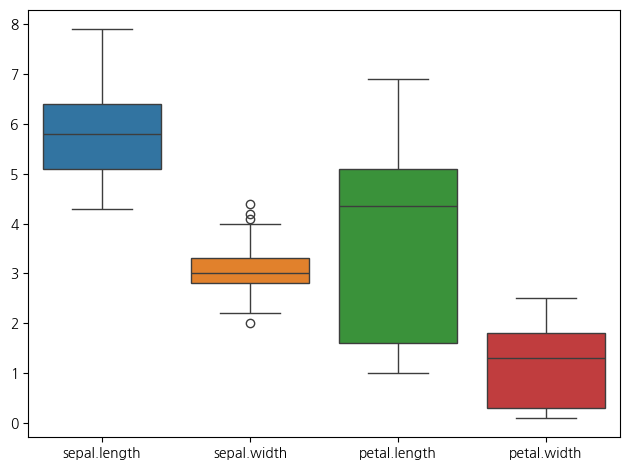

In [55]:
# -------------------------------------------------------------
# [2-3] 결측치/이상치/중복값 확인
# -------------------------------------------------------------
check_data_quality(irisDF)

# --- 확인 결과 --- 
#     결측치 X      
#     중복값 O   
#     이상치 O   
# ----------------

In [56]:
# -------------------------------------------------------------
# [2-4] 전처리 수행
# -------------------------------------------------------------

# 중복값 1개 존재, 확인 후 제거
irisDF.drop_duplicates(inplace=True)

print(f"=== 중복값 제거 후 확인 ===\n{irisDF.duplicated().sum()}\n")     

# 이상치 분석 
analysis_outlier(irisDF)

# sepal.width 컬럼에 이상치 4개 존재, 확인 후 제거
cleanDF = analysis_outlier(irisDF, True, "sepal.width")
print(cleanDF.describe())

=== 중복값 제거 후 확인 ===
0

=== 이상치 분석 ===
【sepal.length】 범위: [3.15, 8.35]
  이상치: 0개 (상한: 0, 하한: 0)

【sepal.width】 범위: [2.05, 4.05]
  이상치: 4개 (상한: 3, 하한: 1)
  값: [np.float64(2.0), np.float64(4.1), np.float64(4.2), np.float64(4.4)]

【petal.length】 범위: [-3.65, 10.35]
  이상치: 0개 (상한: 0, 하한: 0)

【petal.width】 범위: [-1.95, 4.05]
  이상치: 0개 (상한: 0, 하한: 0)

=== 이상치 분석 ===
【sepal.length】 범위: [3.15, 8.35]
  이상치: 0개 (상한: 0, 하한: 0)

【sepal.width】 범위: [2.05, 4.05]
  이상치: 4개 (상한: 3, 하한: 1)
  값: [np.float64(2.0), np.float64(4.1), np.float64(4.2), np.float64(4.4)]
  ✓ 제거됨: 149행 → 145행

【petal.length】 범위: [-3.65, 10.35]
  이상치: 0개 (상한: 0, 하한: 0)

【petal.width】 범위: [-1.95, 4.05]
  이상치: 0개 (상한: 0, 하한: 0)

       sepal.length  sepal.width  petal.length  petal.width
count    145.000000   145.000000    145.000000   145.000000
mean       5.857241     3.042759      3.797931     1.215862
std        0.836971     0.398216      1.760819     0.759905
min        4.300000     2.200000      1.000000     0.100000
25%        5

[3] 학습관련 전처리 및 준비 <HR>

이진 분류(Setosa와 Others)

In [57]:
# iris 품종 확인
print(irisDF['variety'].unique())

['Setosa' 'Versicolor' 'Virginica']


In [58]:
# -------------------------------------------------------------
# [3-1] 이진 분류(Setosa와 Other)
# -------------------------------------------------------------
cleanDF['variety'] = cleanDF['variety'].apply(
    lambda x:'Setosa' if x == 'Setosa' else 'Others'
)

C:\Users\khw27\AppData\Local\Temp\ipykernel_23320\2150285949.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanDF['variety'] = cleanDF['variety'].apply(


<Axes: xlabel='petal.length', ylabel='petal.width'>

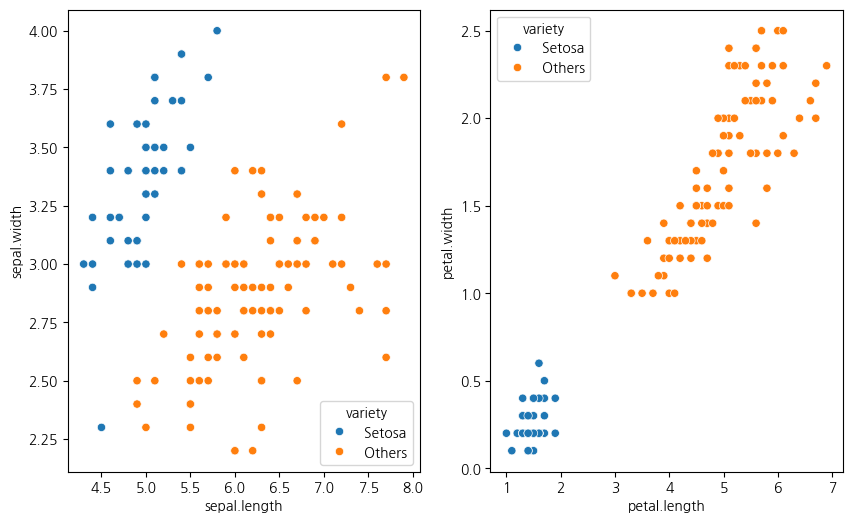

In [59]:
# -------------------------------------------------------------
# [3-2] 피쳐 선정
# -------------------------------------------------------------
# 명확하게 나누어져있는 petal.length/petal.width 컬럼을 피쳐로 사용
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

sns.scatterplot(data=cleanDF, x=cleanDF['sepal.length'], y=cleanDF['sepal.width'], hue=cleanDF['variety'], ax=axes[0])
sns.scatterplot(data=cleanDF, x=cleanDF['petal.length'], y=cleanDF['petal.width'], hue=cleanDF['variety'], ax=axes[1])

In [60]:
# -------------------------------------------------------------
# [3-3] 피쳐와 타켓 분리
# -------------------------------------------------------------
featureDF = cleanDF[cleanDF.columns[2:4]]
# print(featureDF)
targetSR = cleanDF[cleanDF.columns[4]]
# print(targetSR)

In [61]:
# -------------------------------------------------------------
# [3-3] 학습용, 테스트용 데이터셋 분리
# -------------------------------------------------------------
train_feature, test_feature, train_target, test_target = train_test_split(
    featureDF,
    targetSR,
    test_size=0.2,      # 20% 테스트용으로 사용
    random_state=7,   
    stratify=targetSR   # 클래스 비율 유지
    )

# 피쳐, 타겟별 학습용, 테스트용 데이터 개수
print("=== 개수와 차원 ===")
print(f'[학습용 피쳐, 타겟]  \n{train_feature.shape} {train_feature.ndim}D, {train_target.shape} {train_target.ndim}D')
print(f'[테스트용 피쳐, 타겟]\n{test_feature.shape} {test_feature.ndim}D, {test_target.shape} {test_target.ndim}D\n')

print("=== 타겟 분포 ===")
print(f"[학습용 타겟]  \n{train_target.value_counts()}")
print(f"[테스트용 타겟]\n{test_target.value_counts()}")

=== 개수와 차원 ===
[학습용 피쳐, 타겟]  
(116, 2) 2D, (116,) 1D
[테스트용 피쳐, 타겟]
(29, 2) 2D, (29,) 1D

=== 타겟 분포 ===
[학습용 타겟]  
variety
Others    78
Setosa    38
Name: count, dtype: int64
[테스트용 타겟]
variety
Others    20
Setosa     9
Name: count, dtype: int64


In [62]:
# -------------------------------------------------------------
# [3-4] 피쳐(수치형) 스케일링
# -------------------------------------------------------------
# 스케일링을 해야 할까?
print(train_feature.describe(), '\n')
# petal.length = 1.0 ~ 6.9(5.9 범위)(std=1.73)
# petal.width  = 0,1 ~ 2.5(2.4 범위)(std=0.75)
# petal.length가 범위/std 둘 다 커서(데이터 넓게 퍼지고 값도 큼) 
# 모델이 petal.width를 무시하고 학습할 수 있음 -> 스케일링 작업을 통해 균등하게 맞춤

# 학습용 데이터셋 기반 스케일러 생성
std_scaler = StandardScaler()
std_scaler.fit(train_feature)
print(f"모델 파라미터 : \n평균   : {std_scaler.mean_}\n분산   : {std_scaler.var_}\n표준편차: {std_scaler.scale_}\n")

## 학습용/테스트용 데이터셋 스케일링 진행 => ndarray 타입 
train_scaled = std_scaler.transform(train_feature)
test_scaled  = std_scaler.transform(test_feature)

# 스케일링 결과 확인(원본 vs 스케일링)
print(train_feature[:5], '\n')
print(train_scaled[:5], '\n')

       petal.length  petal.width
count    116.000000   116.000000
mean       3.825000     1.241379
std        1.782762     0.767613
min        1.000000     0.100000
25%        1.600000     0.300000
50%        4.450000     1.400000
75%        5.125000     1.900000
max        6.700000     2.500000 

모델 파라미터 : 
평균   : [3.825      1.24137931]
분산   : [3.15084052 0.58414982]
표준편차: [1.77506071 0.76429695]

     petal.length  petal.width
112           5.5          2.1
7             1.5          0.2
0             1.4          0.2
130           6.1          1.9
55            4.5          1.3 

[[ 0.9436297   1.12341243]
 [-1.30981436 -1.36253235]
 [-1.36615046 -1.36253235]
 [ 1.28164631  0.86173403]
 [ 0.38026868  0.07669884]] 



[4] 학습 진행 <hr>

{'k': 3, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 5, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 7, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 9, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 11, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 13, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 15, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 17, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 19, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 21, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 23, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 25, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 27, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 29, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 31, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 33, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 35, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 37, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 39, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 41, 'basic_test': 1.0, 'scaled_test': 1.0}
{'k': 43, 'basic_test': 

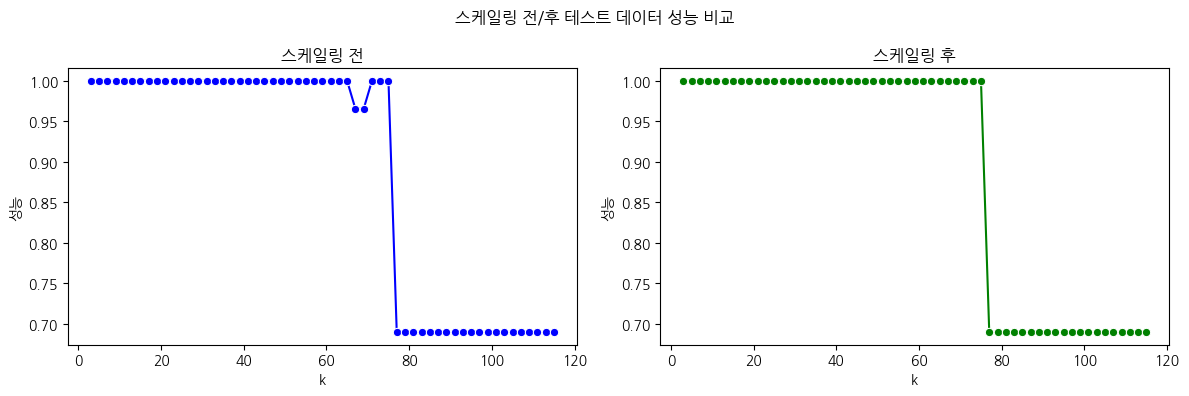

In [63]:
# -------------------------------------------------------------
# [4-1] 최적의 K값 찾기
# -------------------------------------------------------------
k_values = range(3, len(train_target), 2)  # 3부터 100까지 2씩 증가 (홀수만)
results = []

for k in k_values:

    # 1. 모델 생성
    model_basic = KNeighborsClassifier(n_neighbors=k)
    model_scaled = KNeighborsClassifier(n_neighbors=k)

    # 2. 모델 훈련 
    model_basic.fit(train_feature, train_target)
    model_scaled.fit(train_scaled, train_target)
    
    # 3. 학습 점수
    basic_test = model_basic.score(test_feature, test_target)
    scaled_test = model_scaled.score(test_scaled, test_target)

    results.append({
        'k': k,
        'basic_test': basic_test,
        'scaled_test': scaled_test
    })
    
    print(results[-1])
    
# -------------------------------------------------------------
# [4-2] 시각화
# -------------------------------------------------------------
results_df = pd.DataFrame(results)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 왼쪽: 스케일링 전
sns.lineplot(data=results_df, x='k', y='basic_test', marker='o', ax=ax1, color='blue')
ax1.set_title('스케일링 전')
ax1.set_ylabel('성능')

# 오른쪽: 스케일링 후
sns.lineplot(data=results_df, x='k', y='scaled_test', marker='o', ax=ax2, color='green')
ax2.set_title('스케일링 후')
ax2.set_ylabel('성능')

plt.suptitle('스케일링 전/후 테스트 데이터 성능 비교')
plt.tight_layout()
plt.show()

In [64]:
t_model_basic = KNeighborsClassifier(n_neighbors=75)
t_model_scaled = KNeighborsClassifier(n_neighbors=75)

t_model_basic.fit(train_feature, train_target)
t_model_scaled.fit(train_scaled, train_target)

t_model_basic_score = t_model_basic.score(train_feature, train_target)
t_model_scaled_score = t_model_scaled.score(train_scaled, train_target)

print(f"스케일링 전 훈련용 데이터 : {t_model_basic_score}")
print(f"스케일링 후 훈련용 데이터 : {t_model_scaled_score}\n")

스케일링 전 훈련용 데이터 : 1.0
스케일링 후 훈련용 데이터 : 1.0



In [65]:
# 【스케일링 전】
#   K = 3~75: 100%   (완벽)
#   K = 77~ : 70%    (급락)

# 【스케일링 후】
    # K = 3~75: 100% (완벽)
    # K = 77~ : 70%  (급락)

#   최적의 K = 75

#   성능 비교: 
#       K=3~75에서 모두 100%로 동일하며, K=77부터 급락하여 70%로 떨어짐

#   최적의 k 선택 이유: 
#       1. 100% 성능을 유지하는 범위가 K=3~75로 매우 넓기 때문에, 안정성을 최대화하기 위해 범위 내에서 가장 큰 K값인 75를 선택
#       2. 이진분류는 피처가 2개뿐이라 데이터가 명확하게 분리되어 있어서 큰 K값을 사용해도 성능 저하가 없음

[5] 데이터 예측 <hr>

In [66]:
## petal의 너비/무게 ==> 품종 예측
in_data = input("꽃의 꽃잎 너비와 길이 입력(예:5.1 1.9):").strip().split()
in_data  = list(map(float, in_data))
print(f'new_data : {in_data}', end=' ')

## DF 형식으로 저장
new_data = pd.DataFrame([in_data] , columns=irisDF.columns[2:-1])

## 스케링일 진행
s_new_data = std_scaler.transform(new_data)
print(f'=> s_new_data : {s_new_data}' )

new_data : [] 

ValueError: 2 columns passed, passed data had 0 columns

In [ ]:
## 예측 진행
pre_target = t_model_scaled.predict(s_new_data)
proba_ = t_model_scaled.predict_proba(s_new_data)   # 예측 확률
print(f"Others => {proba_[0][1]}%, Setosa : {proba_[0][0]}%")


print(f'무게 {in_data[0]}g, 길이 {in_data[1]}mm 생선은 {pre_target.item()}입니다.')

Setosa => 1.0%, other : 0.0%
무게 5.1g, 길이 1.9mm 생선은 Others입니다.


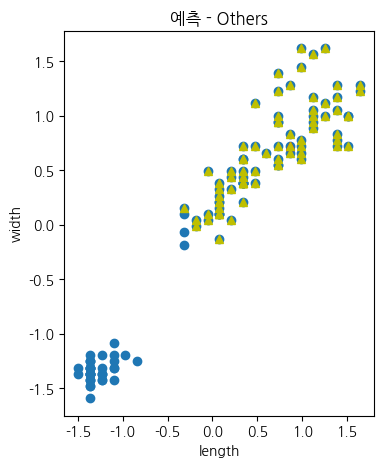

In [ ]:
## 예측 검사
_, sIndices = t_model_scaled.kneighbors(s_new_data)
(train_scaled, train_target)
## 시각화 
plt.figure(figsize=(4, 5))
plt.scatter(train_scaled[:, 1], train_scaled[:, 0])

#-> 새로운 데이터
plt.plot(s_new_data[0][1], s_new_data[0][0], '^r')

# #-> 이웃 데이터
nIdx = sIndices[0].tolist()
for idx in nIdx:
    plt.plot(train_scaled[idx][1], train_scaled[idx][0], '^y')

plt.xlabel('length')
plt.ylabel('width')
plt.title(f'예측 - {pre_target.item()}')
plt.show()